# V0 Algo - Evaluating the performance of our retrieval algorithm

And the resulting taxonomy it creates.

In [42]:
import os 
import sys 
import networkx as nx
import matplotlib as mpl
import numpy as np
import pprint
import tqdm
import pandas as pd

from sentence_transformers import SentenceTransformer
# Add the project root directory to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

from src.etl_module import etl_functions, embedding_functions
from src.processing_module import v0_retrieval, v1_retrieval
from src.evaluation_module import output_functions, graph_scoring_functions

In [13]:
# Load the document index
document_index = etl_functions.load_documents()

# Embed the document index
embedded_index = embedding_functions.embed_index(document_index)

# Create the graph
graph = graph_scoring_functions.construct_graph_top_k(
    embedded_index,
    v0_retrieval.retrieve_top_k,
    edge_threshold=0.5,
    k=5
)

graph_eval = graph_scoring_functions.evaluate_graph(graph)

Constructing Graph: 100%|██████████| 197/197 [00:05<00:00, 36.40it/s]


In [14]:
# View the results without the communities (as its long)
{k: v for k, v in graph_eval.items() if k != 'communities'}

{'number_of_nodes': 197,
 'number_of_edges': 562,
 'average_degree': 5.7055837563451774,
 'density': 0.029110121205842745,
 'clustering_coefficient': 0.3826222713078177,
 'average_node_connectivity': 4.21972443799855,
 'edge_connectivity': 2,
 'node_connectivity': 2,
 'average_shortest_path_length': 4.086915984667979,
 'diameter': 8,
 'degree_assortativity': 0.004376782266041703,
 'source_assortativity': 0.04014279843846328,
 'page_assortativity': 0.001605254608105012,
 'date_assortativity': 0.04014279843848181,
 'num_communities': 9,
 'community_modularity': 0.6736253078974219,
 'precision_lclglbl': 0.7904937701892016,
 'recall_lclglbl': 0.7258883248730964,
 'f1_lclglbl': 0.7030144367982112,
 'precision_harmonic': 1.0,
 'recall_harmonic': 1.0,
 'f1_harmonic': 1.0}

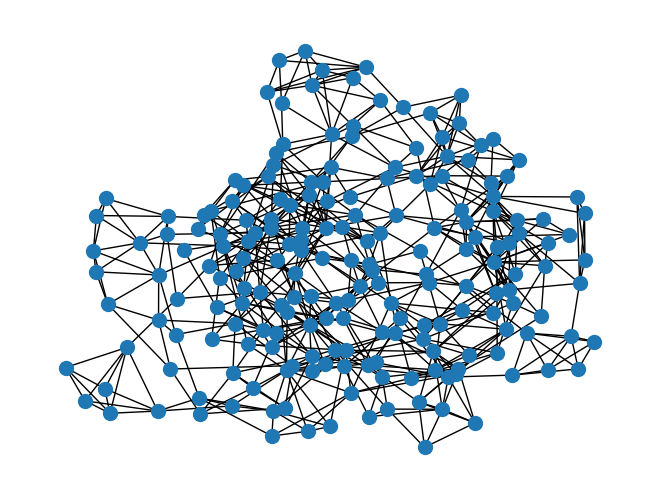

In [15]:
# Visualise the generated graph
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100)

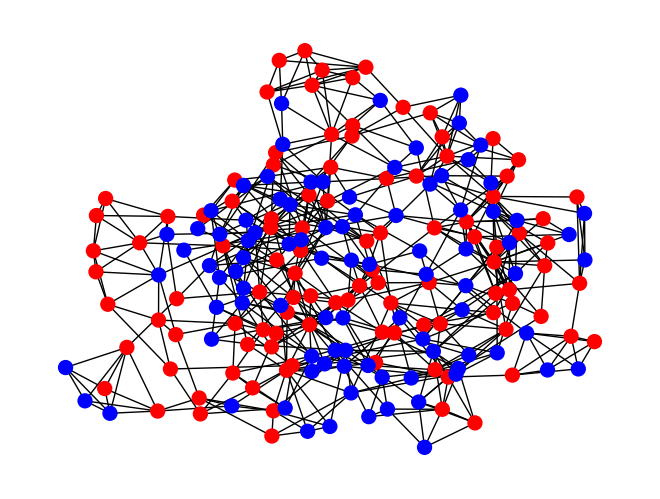

In [16]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in document_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in graph.nodes:
    for doc in document_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=colors)

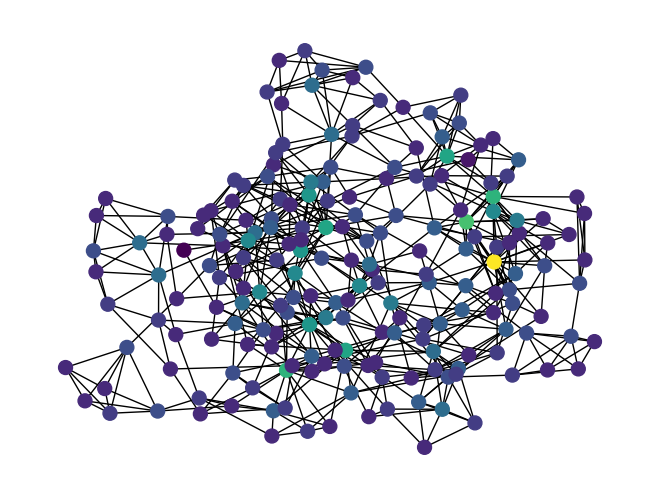

In [17]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=color_map)

## Evaluating the detected communities

The modularity of this method is: 0.6736253078974219


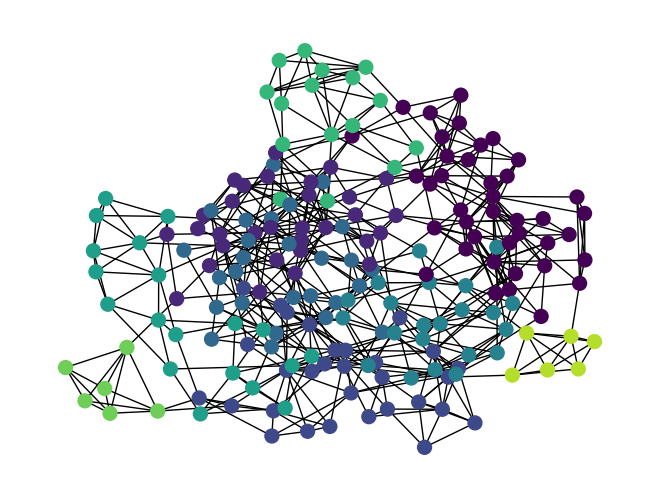

In [18]:
community_node_list = graph_eval['communities']

# Split viridis into n colors
n = len(community_node_list)
viridis = mpl.colormaps['viridis']
colors = [viridis(i/n) for i in range(n)]

# Create a dictionary that maps each community to a color
community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

node_colors = []

for node in graph.nodes:
    # Find which community the node belongs to
    for community, color in community_color_dict.items():
        if node in community:
            node_colors.append(color)

# Draw the graph with the communities colored
pos = nx.kamada_kawai_layout(graph)
nx.draw(graph, pos, node_size=100, node_color=node_colors)

# Print the modularity of the partition
print("The modularity of this method is:", graph_eval['community_modularity'])

In [19]:
# Do some evaluation for each of the communities detected.
for com_nodes in community_node_list:
    subgraph = graph.subgraph(com_nodes)
    subgraph_eval = graph_scoring_functions.simple_stats(subgraph)
    subgraph_eval2 = graph_scoring_functions.attribute_stats(subgraph)
    
    pprint.pprint(subgraph_eval)
    pprint.pprint(subgraph_eval2)
    
    print("-------------------")

{'average_degree': 5.35,
 'average_node_connectivity': 3.287179487179487,
 'average_shortest_path_length': 2.562820512820513,
 'clustering_coefficient': 0.5194190531690533,
 'density': 0.1371794871794872,
 'diameter': 5,
 'edge_connectivity': 2,
 'node_connectivity': 2,
 'number_of_edges': 107,
 'number_of_nodes': 40}
{'date_assortativity': 0.04179104477710734,
 'degree_assortativity': -0.09677102436468417,
 'page_assortativity': -0.04233430444282593,
 'source_assortativity': 0.041791044776119314}
-------------------
{'average_degree': 4.774193548387097,
 'average_node_connectivity': 3.1806451612903226,
 'average_shortest_path_length': 2.587096774193548,
 'clustering_coefficient': 0.3698668714797747,
 'density': 0.15913978494623657,
 'diameter': 6,
 'edge_connectivity': 2,
 'node_connectivity': 2,
 'number_of_edges': 74,
 'number_of_nodes': 31}
{'date_assortativity': -0.1426470588236823,
 'degree_assortativity': -0.05770248808893468,
 'page_assortativity': -0.03278845234681197,
 'sourc

# V1 algorithm Graph Eval
1. Write the code to create the graph in a more efficient way
2. This is using a dict-of-dicts approach - the pure python approach to an adjacency matrix.

In [20]:
from src.processing_module import multiprocessed_graph
import pickle

# Calc the adj dict.
adj_dict = multiprocessed_graph.construct_adjacency_dict(embedded_index)

# Save the result to a pickle
with open('../data/03_output/adjacency_dict.pkl', 'wb') as f:
    pickle.dump(adj_dict, f)

Processing chunk e39316ec-5cec-414b-92b1-ee04efbd9d65: 100%|██████████| 21/21 [10:14<00:00, 29.26s/it]
Processing chunk 8e6fe68c-59f0-433b-8213-9d395b8a1cf2: 100%|██████████| 22/22 [10:19<00:00, 28.15s/it]
Processing chunk 0d2e7430-2d59-4d70-9377-6f153d304017: 100%|██████████| 22/22 [10:20<00:00, 28.20s/it]
Processing chunk 2dcffd12-d22f-4e00-8237-44da5ed331e7: 100%|██████████| 22/22 [10:22<00:00, 28.28s/it]
Processing chunk 71b9beaf-9935-4817-8c79-af23a5a92584: 100%|██████████| 22/22 [10:24<00:00, 28.37s/it]
Processing chunk ee0984a0-e839-48da-88e0-2040fa9fbc8f: 100%|██████████| 22/22 [10:27<00:00, 28.51s/it]
Processing chunk 906a285e-1c98-436e-b5f9-1d629a88dea3: 100%|██████████| 22/22 [10:27<00:00, 28.51s/it]
Processing chunk 3b3a7d88-5033-40b7-ab05-efaaf7b24da0: 100%|██████████| 22/22 [10:28<00:00, 28.57s/it]
Processing chunk bb670fae-1ac2-4be8-9318-589bac49b031: 100%|██████████| 22/22 [10:28<00:00, 28.58s/it]
Total progress: 100%|██████████| 9/9 [10:37<00:00, 70.87s/it]


In [28]:
len(adj_dict[list(adj_dict.keys())[0]]) # Should be 197 (number of documents in the index)

196

In [61]:
# Read the adj_dict back in
with open('../data/03_output/adjacency_dict.pkl', 'rb') as f:
    adj_dict = pickle.load(f)

In [71]:
def construct_graph_from_adj_dict(adj_dict, edge_thresh, embedded_index) -> nx.Graph:
    
    # Copy the adjacency dict
    adj_dict_local = adj_dict.copy()
    
    # Iterate over the adjacency dict to remove every edge which links a node to the same node
    for node0, edge_dict in adj_dict_local.items():
        for node1, weight in list(edge_dict.items()):
            
            # Remove matching nodes
            if node0 == node1:
                del edge_dict[node1]
            
            # Remove edges with low weights
            if weight['weight'] < edge_thresh:
                del edge_dict[node1]

    # Construct a graph
    graph = nx.Graph()
    
    # Add the nodes
    for node in adj_dict_local.keys():
        matching_doc = [doc for doc in embedded_index if doc.id_ == node][0]
        graph.add_node(
            node,
            **matching_doc.metadata, 
            date_num=int(pd.Timestamp(matching_doc.metadata['Date']).timestamp())
        )
        
    # Add the edges
    for node, edge_bunch in adj_dict.items():
        for node2, edge_weight in edge_bunch.items():
            # if edge_weight['weight'] > edge_thresh:
            graph.add_edge(node, node2, weight=edge_weight['weight'])

    return graph

# Construct the graph
graph2 = construct_graph_from_adj_dict(adj_dict, 0.93, embedded_index)

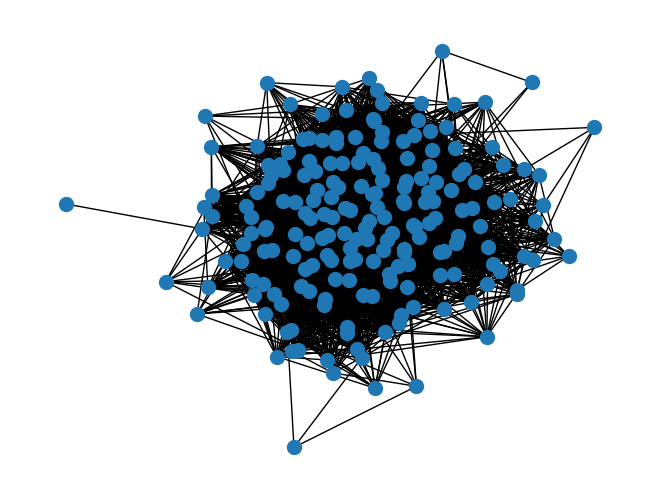

In [72]:
# test_G = nx.Graph(adj_dict)

pos_test_G = nx.kamada_kawai_layout(graph2)
nx.draw(graph2, pos_test_G, node_size=100)


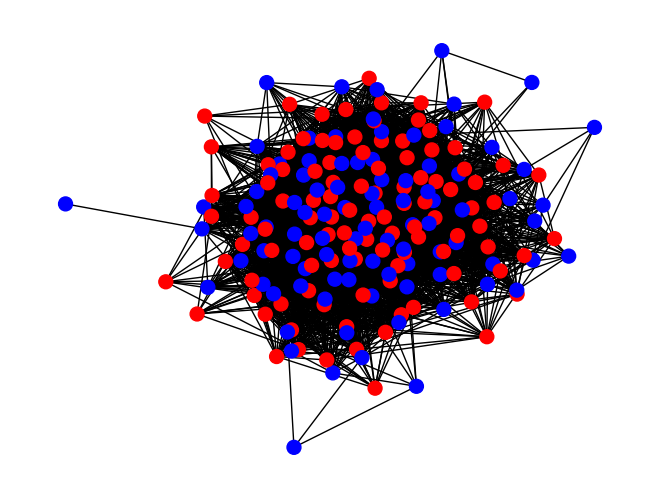

In [73]:
# Draw the graph, but use the node_id to identify which of the two headline document elements is referenced within the node
unique_docs = []
for doc in document_index:
    unique_docs.append(doc.metadata['file_name'])
    
set(unique_docs)

colors = []
for n in graph2.nodes:
    for doc in document_index:
        if doc.id_ == n:
            if doc.metadata['file_name'] == unique_docs[0]:
                colors.append('red')
            else:
                colors.append('blue')
                
pos = nx.kamada_kawai_layout(graph2)
nx.draw(graph2, pos, node_size=100, node_color=colors)

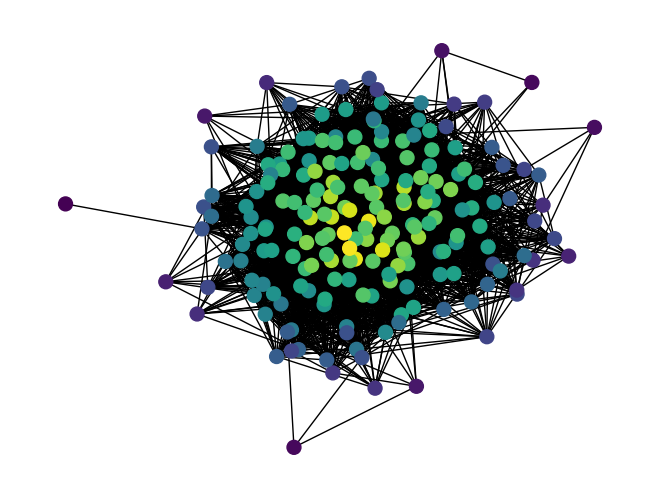

In [74]:
# Step 1: Compute centrality measures
centrality = nx.degree_centrality(graph2)

# Color the nodes along a gradient of centrality
color_map = []
for node in graph.nodes:
    color_map.append(centrality[node])
    
# Step 2: Normalize the centrality values
min_centrality = min(color_map)
max_centrality = max(color_map)
color_map = [(centrality - min_centrality) / (max_centrality - min_centrality) for centrality in color_map]

# Step 3: Convert the color map to a list of RGB values using viridis colormap
cmap = mpl.colormaps['viridis']
color_map = [cmap(color) for color in color_map]

# Step 4: Draw the graph with the color map
pos = nx.kamada_kawai_layout(graph2)
nx.draw(graph2, pos, node_size=100, node_color=color_map)

In [75]:
# Get our graph metrics
v1_graph_eval = graph_scoring_functions.evaluate_graph(graph2)

In [76]:
v1_graph_eval

{'number_of_nodes': 197,
 'number_of_edges': 4997,
 'average_degree': 50.73096446700507,
 'density': 0.2588314513622708,
 'clustering_coefficient': 0.7535783408501314,
 'average_node_connectivity': 19.3428985807521,
 'edge_connectivity': 0,
 'node_connectivity': 0,
 'average_shortest_path_length': None,
 'diameter': None,
 'degree_assortativity': 0.07895958428649155,
 'source_assortativity': 1.0,
 'page_assortativity': -0.011060336086943227,
 'date_assortativity': 1.0000000000005556,
 'num_communities': 2,
 'communities': [frozenset({'025292d0-ff5f-4a94-8d60-91b7e12a8096',
             '043c78e5-9d59-4142-9d28-7b592d28aa93',
             '0732b0f5-c96f-47a1-a3e7-fa1e40e3c6f7',
             '0d2e7430-2d59-4d70-9377-6f153d304017',
             '1149299b-6cc6-4dbb-9b35-18f94622534d',
             '127fc731-b24f-4bd0-b6a5-58036fd3870a',
             '13802cdb-71f6-4cf0-a440-05f66116e46f',
             '15303104-bc4a-4a52-a762-6fbded25edcf',
             '1ac1a258-325a-4363-8bab-8e02bd89fa1

The modularity of this method is: 0.4815439047432264


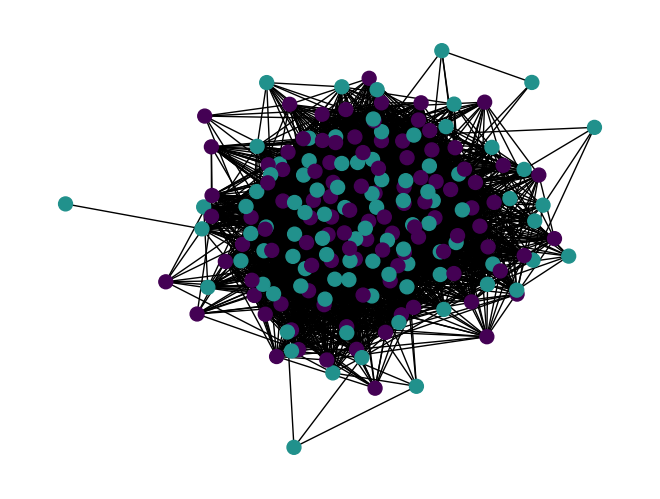

In [77]:
community_node_list = v1_graph_eval['communities']

# Split viridis into n colors
n = len(community_node_list)
viridis = mpl.colormaps['viridis']
colors = [viridis(i/n) for i in range(n)]

# Create a dictionary that maps each community to a color
community_color_dict = {community: color for community, color in zip(community_node_list, colors)}

node_colors = []

for node in graph2.nodes:
    # Find which community the node belongs to
    for community, color in community_color_dict.items():
        if node in community:
            node_colors.append(color)

# Draw the graph with the communities colored
pos = nx.kamada_kawai_layout(graph2)
nx.draw(graph2, pos, node_size=100, node_color=node_colors)

# Print the modularity of the partition
print("The modularity of this method is:", v1_graph_eval['community_modularity'])